# Molecular Isotopic Distributions Part 2: Combinations

In [71]:
%%capture
%!pip install rdkit
%!pip install mendeleev

In [72]:
from collections import defaultdict
import math
import copy

from IPython.display import display, Markdown
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

from mendeleev import element
from rdkit import Chem
from rdkit.Chem import Descriptors

In [73]:
# Carbon tetrachloride
sml = "ClC(Cl)(Cl)Cl"
mol = Chem.MolFromSmiles(sml)

In [74]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      mol: Chem.rdchem.Mol = None,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    if mol is not None:
      self.mol = mol
    else:
      try:
        self.mol = Chem.MolFromSmiles(sml)
      except:
        self.mol = Chem.MolFromSmiles(sml, sanitize=False)
  def update(self):
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(self.mol)
  def get_mass(self):
    return self.mass

In [75]:
def composition(
        molecule: Chem.Mol,
        isotopes=False):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        molecule = Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule.GetAtoms():
            element_symbol = atom.GetSymbol()
            # If isotopes not requested, simply count the number of atoms of each element
            if not isotopes:
                comp[element_symbol] += 1
            # If isotopes requested, count the number of each isotope of each element
            else:
                isotope = atom.GetIsotope()
                try:
                    comp[element_symbol][isotope] += 1
                except:
                    comp[element_symbol] = defaultdict(lambda: 0)
                    comp[element_symbol][isotope] += 1
        return comp

In [76]:
def flatten_ndarray(arr):
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

In [77]:
def binomial_coefficient(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

In [78]:
def distribute_items(n, k):
    def backtrack(remaining_items, bins, current_bin):
        if current_bin == k:
            if remaining_items == 0:
                results.append(list(bins))
            return

        for items_in_current_bin in range(remaining_items + 1):
            bins[current_bin] = items_in_current_bin
            backtrack(remaining_items - items_in_current_bin, bins, current_bin + 1)

    results = []
    bins = [0] * k
    backtrack(n, bins, 0)
    return results

In [79]:
#? Replace with newer version?
def atom_set(molecule):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

In [80]:
set_of_atoms = atom_set(mol)
print(set_of_atoms)
isotopes = {}
for atom in set_of_atoms:
  # print(f"{atom=}")
  # print(f"{element(atom)=}")
  element_isotopes = element(atom).isotopes
  occuring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[atom] = occuring_isotopes
print(isotopes)

{'C', 'Cl'}
{'C': [[12, 0.9894], [13, 0.0106]], 'Cl': [[35, 0.758], [37, 0.242]]}


In [81]:
def print_ndarray_elements(arr, prefix=''):
    if isinstance(arr, Chem.Mol):
        print(prefix + Chem.MolToSmiles(arr))
    else:
        for i in range(len(arr)):
            new_prefix = prefix + "[" + str(i) + "]"
            print_ndarray_elements(arr[i], new_prefix)

In [82]:
def extract_properties(arr, prop_name):
    if isinstance(arr, np.ndarray):
        # If arr is a NumPy ndarray, iterate through its elements and apply the function recursively
        return np.array([extract_properties(item, prop_name) for item in arr])
    elif isinstance(arr, list):
        # If arr is a list, iterate through its elements and apply the function recursively
        return [extract_properties(item, prop_name) for item in arr]
    elif hasattr(arr, prop_name):
        # If arr has the specified property, extract its value
        return getattr(arr, prop_name)
    else:
        # If the property is not found, return None
        return None

In [83]:
def assign_isotopes(
      arr, 
      isotope_count_distribution, 
      prefix,
      this_element,
      n_this_element,
      ):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            new_prefix = prefix + [i]
            assign_isotopes(
               arr = arr[i], 
               isotope_count_distribution = isotope_count_distribution, 
               prefix = new_prefix, 
               this_element = this_element,
               n_this_element = n_this_element,
               )
    else:
        # Clone the distribution, making it independent so the next loop won't be affected
        distribution = copy.deepcopy(isotope_count_distribution[prefix[0]])

        # Calculate abundances
        if arr.abundance is None:
           arr.abundance = 1
        a = 1
        b = binomial_coefficient(n_this_element, distribution[0])
        for isotope_index, isotope_count in enumerate(distribution):
          a_this_isotope = isotopes[this_element][isotope_index][1]
          a *= a_this_isotope**isotope_count
        arr.abundance *= a*b

        # print(f"{distribution=}")
        # Assign isotopes to atoms of this element type
        for atom in arr.mol.GetAtoms():
          if atom.GetSymbol() == this_element:
            # Count down each isotope, going on to the next when zero
            for isotope_index, isotope in enumerate(distribution):
              if distribution[isotope_index] > 0:
                  atom.SetIsotope(isotopes[this_element][isotope_index][0])
                  distribution[isotope_index] -= 1
                  # If assign isotope to this atom, move on to next atom
                  break

        isotopes_list = []
        for atom in arr.mol.GetAtoms():
          isotopes_list.append(atom.GetIsotope())
    return arr

In [84]:
def update_molecular_isotopes(
      arr, 
      ):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            update_molecular_isotopes(arr[i])
    elif isinstance(arr, MolecularIsotope):
        arr.update()

In [85]:
# Initialize ndarray to hold MolecularIsotope objects
molecular_isotopes:np.ndarray = np.array(MolecularIsotope)

# Loop through the elements in this molecule
for this_element, n_this_element in composition(mol).items():
  n_isotopes_this_element = len(isotopes[this_element])

  # Calculate possible distributions of isotopes across atoms of this element
  isotope_count_distribution = distribute_items(n_this_element, n_isotopes_this_element)
  n_distributions = len(isotope_count_distribution)

  if molecular_isotopes.shape == ():
     # Start by creating a 1-dimensional array,
     # making sure to make each mol an independent object
     molecular_isotopes = np.array([MolecularIsotope(sml=sml, mol=Chem.Mol(mol)) for _ in range(n_distributions)], dtype=object)
  else:
    # Create a list of m copies of the current object, 
    # namely the n-1 dimensional ndarray representing elements prior to this element
    molecular_isotopes_list = [copy.deepcopy(molecular_isotopes) for _ in range(n_distributions)]
    
    # Convert the list of copies to a NumPy ndarray
    molecular_isotopes = np.array(molecular_isotopes_list, dtype=object)
    
  # Assign isotopes and abundances
  molecular_isotopes = assign_isotopes(
     arr=molecular_isotopes,
     isotope_count_distribution=isotope_count_distribution, 
     prefix=[],
     this_element=this_element,
     n_this_element=n_this_element,
     )
  
# Update the properties of each MolecularIsotope to get exact masses
update_molecular_isotopes(molecular_isotopes)

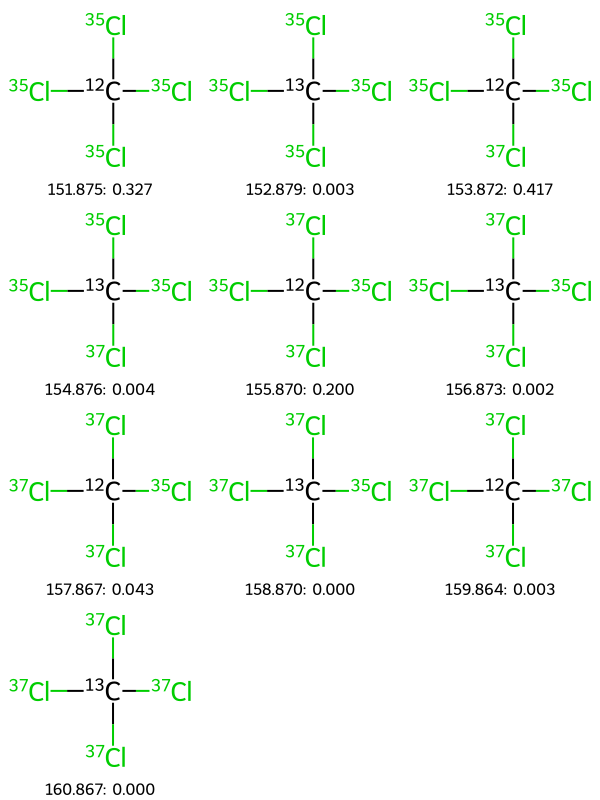

In [86]:
molecular_isotopes_flat = flatten_ndarray(molecular_isotopes)
masses_array_flat = list(extract_properties(molecular_isotopes_flat, "mass"))
order = np.argsort(masses_array_flat).tolist()

sorted_molecular_isotopes = sorted(molecular_isotopes_flat, key=lambda x: order.index(molecular_isotopes_flat.index(x)))
mols_flat_sorted = extract_properties(sorted_molecular_isotopes, "mol")
masses_flat_sorted = extract_properties(sorted_molecular_isotopes, "mass")
abundances_flat_sorted = extract_properties(sorted_molecular_isotopes, "abundance")
legends_flat = [f"{mass:.3f}: {abundance:.3f}" for mass, abundance in zip(masses_flat_sorted, abundances_flat_sorted)]

Chem.Draw.MolsToGridImage(mols_flat_sorted, legends=legends_flat, subImgSize=(200, 200)) #, legends=[str(mass) for mass in masses])

In [87]:
def mol_to_formatted_formula(
    mol: Chem.Mol,
    isotopes: bool = False,
) -> dict[str, str]:
    if mol is None:
        return "Invalid molecule"
    comp = composition(mol, isotopes)

    formula = {"markdown": "", "latex": ""}

    if isotopes:
        isotopes_dict = defaultdict(lambda: defaultdict(str))
        subscripts = defaultdict(lambda: defaultdict(int))
        superscripts = defaultdict(list)

        for element, counts in comp.items():
            for isotope, count in counts.items():
                if count > 1:
                    subscripts[element][isotope] = count
                if isotope != 0:
                    superscripts[element].append(isotope)

                isotopes_dict[element][isotope] = 1
            # Sort the element's isotopes from lowest to highest
            superscripts[element].sort()

        last_item_is_subscript = False
        sorted_element_keys = sorted(isotopes_dict.keys())
        for element in sorted_element_keys:
            isotope_count_pairs = isotopes_dict[element]
            # Sort the element's isotopes from lowest to highest
            sorted_isotope_keys = sorted(isotope_count_pairs.keys())
            for isotope in sorted_isotope_keys:
                if element in superscripts:
                    if isotope in superscripts[element]:
                        formula["markdown"] += f"<sup>{isotope}</sup>"

                        # If superscript immediately follows subscript,
                        # add a small amount of horizontal space using an empty group {}
                        # to prevent them from vertically overlapping
                        if last_item_is_subscript:
                            formula["latex"] += "{}"
                        formula["latex"] += "^{ %d}" % isotope
                        last_item_is_subscript = False
                formula["markdown"] += element
                formula["latex"] += element
                last_item_is_subscript = False
                if element in subscripts:
                    if isotope in subscripts[element]:
                        isotope_count = subscripts[element][isotope]
                        formula["markdown"] += f"<sub>{isotope_count}</sub>"
                        formula["latex"] += "_{ %d}" % isotope_count
                    last_item_is_subscript = True
        # Add beginning and ending dollar signs to LaTeX formula
        formula["latex"] = "$" + formula["latex"] + "$"
    else:
        # Handling the case when isotopes is False
        sorted_element_keys = sorted(comp.keys())

        for element in sorted_element_keys:
            count = comp[element]
            formula["markdown"] += element
            formula["latex"] += element
            if count > 1:
                formula["markdown"] += f"<sub>{count}</sub>"
                formula["latex"] += "_{ %d}" % count
        formula["latex"] = "$" + formula["latex"] + "$"

    return formula

In [88]:
def dict_list_to_markdown_table(data, number_rows=False):
    """
    Convert a list of dictionaries into a Markdown table.

    Args:
        data (list): A list of dictionaries, where each dictionary corresponds to a row in the table.
        include_row_numbers (bool): Whether to include a row number column.

    Returns:
        str: The Markdown-formatted table as a string.
    """
    if not data:
        return ""

    # Extract column headers from the keys of the first dictionary
    headers = data[0].keys()

    # If include_row_numbers is True, add the "Row #" column
    if number_rows:
        headers = ["#"] + list(headers)

    # Create the table headers
    table = "| " + " | ".join(headers) + " |\n"

    # Create the title divider line
    table += "|"
    for _ in headers:
        table += " --- |"
    table += "\n"

    # Create the table body
    for i, row in enumerate(data):
        if number_rows:
            row_data = [i + 1] + [row.get(header, "") for header in headers[1:]]
        else:
            row_data = [row.get(header, "") for header in headers]

        table += "| " + " | ".join(map(str, row_data)) + " |\n"

    return table

In [89]:
data_dict_list = []
for mol_isotope in sorted_molecular_isotopes:
    mol_isotope.update()
    data_dict = {prop: getattr(mol_isotope, prop) for prop in vars(mol_isotope).keys()}
    data_dict["mol_isotope"] = mol_isotope
    data_dict_list.append(data_dict)
df = pl.DataFrame(data_dict_list).select(["mass", "abundance", "mol"])
df = df.with_columns(
    pl.col("mol").map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["markdown"]).alias("formula")
)

Markdown(
    dict_list_to_markdown_table(
        df.rows(named=True),
        number_rows=True,
        )
    )

| # | mass | abundance | mol | formula |
| --- | --- | --- | --- | --- |
| 1 | 151.87541072 | 0.32662447792098237 | <rdkit.Chem.rdchem.Mol object at 0x17f716ff0> | <sup>12</sup>C<sup>35</sup>Cl<sub>4</sub> |
| 2 | 152.87876555999998 | 0.0034993121750176003 | <rdkit.Chem.rdchem.Mol object at 0x17f714580> | <sup>13</sup>C<sup>35</sup>Cl<sub>4</sub> |
| 3 | 153.87246062999998 | 0.41711410900727036 | <rdkit.Chem.rdchem.Mol object at 0x17f716b20> | <sup>12</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl |
| 4 | 154.87581547 | 0.0044687786087296 | <rdkit.Chem.rdchem.Mol object at 0x17f714270> | <sup>13</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl |
| 5 | 155.86951054 | 0.19975253505229437 | <rdkit.Chem.rdchem.Mol object at 0x17f716960> | <sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> |
| 6 | 156.87286538 | 0.0021400615237055997 | <rdkit.Chem.rdchem.Mol object at 0x17f714040> | <sup>13</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> |
| 7 | 157.86656045 | 0.04251549118967039 | <rdkit.Chem.rdchem.Mol object at 0x17f7146d0> | <sup>12</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> |
| 8 | 158.86991529 | 0.0004554924263296 | <rdkit.Chem.rdchem.Mol object at 0x17f7145f0> | <sup>13</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> |
| 9 | 159.86361036 | 0.0033933868297823994 | <rdkit.Chem.rdchem.Mol object at 0x17f714510> | <sup>12</sup>C<sup>37</sup>Cl<sub>4</sub> |
| 10 | 160.86696519999998 | 3.6355266217599994e-05 | <rdkit.Chem.rdchem.Mol object at 0x17f714660> | <sup>13</sup>C<sup>37</sup>Cl<sub>4</sub> |


#TODO Create graph